# A Stochastic Block Model for Hypergraphs

### Model

* Let $G=(V,E)$ be a hypergraph, where $E$ is the collection of hyperedges.
* Let $H$ be the collection of admissible combinations of nodes, (e.g., if we only consider hyperedges of size less than 10). 
* $G$ is modeled as a collection of random variables ${X_h: h\in H}$.
* $X_h\sim Poisson(\lambda_h)$.
* The mean $\lambda_h$ depends on the (latent) features of nodes in $h$: $$\lambda_h=\sum_k\prod_{i\in h}r_i\theta_{ik},$$ where $\theta_{ik}$ is the percentage of node $i$ in block $k$  ($\sum_{k}\theta_{ik}=1$), and $r_i$ corresponds to the popularity of node $i$.
* Assume $X_h$'s are independent of each other given $\theta=(\theta_i)$ and $r=(r_i)$.
* The distribution of $G$ is given by $$p(G|\theta)=\prod_{h\in H} p(x_h|\theta)$$.
* Method 1: Take a Bayesian approach to estimate $\theta$ and $r$
    * $\theta\sim Dirichlet(\alpha)$.
    * $r\sim lognormal(\beta)$.
    * $P(\theta,r|G)\propto P(G|\theta,r)P(\theta)P(r)$.
    * Sample from $P(\theta,r|G)$.
    * Method 1.1
        * Use Metropolis-Hastings since a closed-form of $P(\theta,r|G)$ is not available.
        * But for large data it is almost impossible to compute $P(G|\theta,r)=\prod_{h\in H} p(x_h|\theta,r)$ since there are so many possible combinations of nodes.
        * Solution: pick a random sample $S\subset H$ and use $\hat{p}=[-\log\prod_{h\in S}p(x_h|\theta,r)]/q(S)$ as an approximate for $P(G|\theta,r)$ in M-H updates.
        * Note that $E[\hat{p}]=-c\log P(G|\theta,r)$, and thus the MCMC chain will converage to $-c\log P(G|\theta,r)$, instead of $P(G|\theta,r)$.
        * To correct for the bias above, resample the chain by accepting each $(\theta,r)$ with probablity $-c\log P(G|\theta,r)/P(G|\theta,r)$
    * Method 1.2
        * Use the exchange algorithm
* Method 2: Use stochastic gradient descent to estimate $\theta$ and $r$
    * Let $\theta_{ij}=\theta_{ij}r_i$, so that we only need to deal with one set of variables $\theta$.

In [1]:
import numpy as np
import scipy.sparse as ssp
import random
from collections import Counter
from scipy.stats import dirichlet, truncnorm, lognorm
import sys
import pickle
import time
# from string import lower
from itertools import combinations, chain
from collections import Counter
from scipy.stats import pearsonr, norm, poisson
from scipy.misc import comb, factorial
import networkx as nx
from collections import deque
from multiprocessing import Pool
from scipy.optimize import minimize, show_options
from functools import partial
# from progressbar import ProgressBar
from scipy.special import factorial

In [2]:
%matplotlib inline
import pylab as plt
import seaborn as sns
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

In [4]:
with open('hyperedges.pickle', 'rb') as handle2:
    hyperedges=pickle.load(handle2)

In [5]:
hyperedges['Anatomy Gene downregulates both']

[(9446,
  25109,
  26391,
  3824,
  12829,
  8676,
  15332,
  34844,
  41472,
  23275,
  38841,
  17359,
  17574,
  36353,
  7808,
  41675,
  13092,
  14483,
  7419,
  43214,
  31001,
  38565,
  33187,
  30651,
  14274,
  22125,
  22949,
  1754,
  2991,
  44336,
  39851,
  3837,
  38158,
  4631,
  11467,
  4605,
  45508,
  28151,
  45430,
  25100,
  24537,
  20806,
  2041,
  36875,
  46075,
  34066,
  2377,
  22781,
  46278,
  27435,
  14869,
  29500,
  16204,
  30539,
  30041,
  5752,
  20321,
  29897,
  9724,
  24680,
  35231,
  24652,
  27228,
  9312,
  21125,
  24738,
  396,
  10949,
  11914,
  3839,
  37932,
  30497,
  37019,
  5149,
  46779,
  23857,
  10583,
  30421,
  24203,
  34038,
  9320,
  8392,
  22432,
  37678,
  18027,
  20836,
  5810,
  8742,
  33702,
  46095,
  2904,
  33500,
  37071,
  37357,
  42475,
  14087,
  43740,
  42231,
  6673,
  17229,
  46339,
  16530,
  35139,
  4800,
  17682,
  19675,
  10626,
  1063,
  39639,
  36544,
  19140,
  45877,
  13155,
  28008,
 

### Toy Network

Counter({(0, 1, 2): 1, (1, 2): 1, (1, 3): 1, (2, 3): 1})


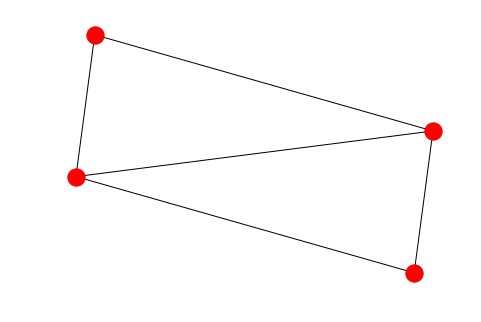

In [3]:
N = 36
V = range(N)
E = Counter(hyperedges['Anatomy Gene downregulates both'])
M = len(E)
H = [h for n in range(1,N) for h in combinations(V,n+1)]
#E = set([(0,1,2),(1,2),(1,3),(2,3)])

print (E)
G=nx.Graph()
G.add_edges_from(set([e for h in E for e in combinations(h,2)]))
nx.draw(G)

### Inference Methods

#### Maximum likelihood estimate

In [ ]:
def ph(h,theta):
    return theta[list(h),:].prod(axis=0).sum()

def logPG(x):
    theta=x.reshape(N,K)
    return -(np.sum([E[h]*np.log(ph(h,theta)) for h in E])-np.sum([ph(h,theta) for h in H]))

def dtheta(i,z,theta):
    res=0
    for j in edgesContain[i]:
        h=H[j]
        hi=list(h)
        hi.remove(i)
        if h in E:
            res+=E[h]*theta[hi,z].prod(axis=0)/(theta[list(h),:].prod(axis=0).sum())
        res-=theta[hi,z].prod(axis=0)
    return -res

def dlogPG(x):
    theta=x.reshape(N,K)
    f=partial(dtheta,theta=theta)
    pool=Pool(10)
    res=pool.map(f,((i,z) for i in V for z in xrange(K)))
    pool.close()
    pool.join()
    return np.array(res)

In [ ]:
K = 3 # dimension of hidden space
theta = np.random.dirichlet([0.5]*K,size=N)
edgesContain=dict([(i, []) for i in V])
for i,h in enumerate(H):
    for u in h:
        edgesContain[u].append(i)

In [ ]:
res=minimize(logPG, 
             theta.reshape(N*K), 
             jac=dlogPG, 
             bounds=[(0,None)]*N*K)
print (res)
theta=res.x.reshape(N,K)

In [ ]:
MSE=[]
for h in H:
    temp=ph(h,theta)
    if h in E:
        print "{}:T {}".format(h,temp)
    else:
        print "{}:F {}".format(h,temp)
    MSE.append(temp-E[h])
print 'Log likelihood: {}'.format(-logPG(res.x))
print "MSE: {}".format((np.array(MSE)**2).sum()/len(MSE))

In [ ]:
r=theta.sum(axis=1)
print r
print theta/r.reshape((N,1))

In [ ]:
fig,ax=plt.subplots(N,K,figsize=(14,12))
for i in V:
    for z in xrange(K):
        X=np.linspace(0.01,4,30)
        theta2=theta.copy()
        Y=[]
        for x in X:
            theta2[i,z]=x
            Y.append(-logPG(theta2))

        ax[i,z].plot(X,Y);
        ax[i,z].plot([theta[i,z]]*2,[min(Y),max(Y)],'--');

In [ ]:
def energy(x,y,i,j,other):
    z=other.copy()
    z[i]=x
    z[j]=y
    return -logPG(z)

newenergy=partial(energy,other=res.x)

In [ ]:
x=np.linspace(0.01,2,10)
y=np.linspace(0.01,2,10)
X,Y=np.meshgrid(x,y)
Z=[[newenergy(i,j,6,7) for j in y] for i in x]
fig=plt.figure()
ax = fig.add_subplot(111,projection='3d')
surf=ax.plot_surface(X,Y,Z, rstride=1, cstride=1, cmap=cm.coolwarm);

#### MLE with stochastic gradient descent

In [ ]:
def ph(h,theta):
    return (theta[list(h),:].prod(axis=0).sum())

def logPG(x):
    theta=x.reshape(N,K)   
    return -np.sum([E[h]*np.log(ph(h,theta))-ph(h,theta) if h in E else -ph(h,theta) for h in HP])

def dtheta((i,z),theta):
    res=0
    for j in edgesContain[i]:
        h=HP[j]
        hi=list(h)
        hi.remove(i)
        if h in E:
            res+=E[h]*theta[hi,z].prod(axis=0)/(theta[list(h),:].prod(axis=0).sum())
        res-=theta[hi,z].prod(axis=0)
    return -res

def dlogPG(x):
    theta=x.reshape(N,K)
    f=partial(dtheta,theta=theta)
    pool=Pool(15)
    res=pool.map(f,((i,z) for i in V for z in xrange(K)))
    pool.close()
    pool.join()
    return np.array(res)

In [ ]:
K = 3 # dimension of hidden space
theta = np.random.dirichlet([0.5]*K,size=N)

In [ ]:
thetaList=[]
likelihoods=[]
for iteration in xrange(100):
    HP=E.keys()
    for h in E:
        while 1:
            e=tuple(sorted(random.sample(V,len(h))))
            if e not in E:
                HP.append(e)
                break
    edgesContain=dict([(i, []) for i in V])
    for i,h in enumerate(HP):
        for u in h:
            edgesContain[u].append(i)
    res=minimize(logPG, 
        theta.reshape(N*K), 
        jac=dlogPG, 
        bounds=[(0.001,None)]*N*K,
        options={"maxiter":1,'maxfun':1})
    theta=res.x.reshape(N,K)
    thetaList.append(theta)
    likelihoods.append(-res.fun)
theta=res.x.reshape(N,K)

In [ ]:
fig,ax=plt.subplots(3,2,figsize=[13,7])
ax[0][0].plot(np.array(thetaList)[:,0,:],'.');
ax[0][1].plot(np.array(thetaList)[:,1,:],'.');
ax[1][0].plot(np.array(thetaList)[:,2,:],'.');
ax[1][1].plot(np.array(thetaList)[:,3,:],'.');
ax[2][0].plot(likelihoods,'.');

In [ ]:
MSE=[]
for h in H:
    temp=ph(h,theta)
    if h in E:
        print "{}:T {}".format(h,temp)
    else:
        print "{}:F {}".format(h,temp)
    MSE.append(temp-E[h])
print 'Log likelihood: {}'.format(-logPG(res.x))
print "MSE: {}".format((np.array(MSE)**2).sum()/len(MSE))

In [ ]:
r=theta.sum(axis=1)
print r
print theta/r.reshape((N,1))

In [ ]:
fig,ax=plt.subplots(N,K,figsize=(14,12))
for i in V:
    for z in xrange(K):
        X=np.linspace(0.01,4,30)
        theta2=theta.copy()
        Y=[]
        for x in X:
            theta2[i,z]=x
            Y.append(-logPG(theta2))

        ax[i,z].plot(X,Y);
        ax[i,z].plot([theta[i,z]]*2,[min(Y),max(Y)],'--');

#### MCMC with full likelihood

In [ ]:
def ph(h,theta):
    return (theta[list(h),:].prod(axis=0).sum())

def logPG(theta):
    return np.sum([E[h]*np.log(ph(h,theta)) for h in E])-np.sum([ph(h,theta) for h in H])

def logPrior(theta):
    return np.sum([np.log(norm.pdf(x,1,10)) for row in theta for x in row])

In [ ]:
K = 3 # dimension of hidden space
theta = np.random.dirichlet([0.5]*K,size=N)
rOld=logPG(theta)

In [ ]:
thetaList=[]
likelihoods=[]
aThetaRate=0.0
for iteration in xrange(1000):
    # Propose new theta
    thetaP = theta+0.01*np.random.randn(N,K)
    thetaP[thetaP<0]=0
    rNew = logPG(thetaP)
    rho = rNew-rOld
    rho+=logPrior(thetaP)-logPrior(theta)
    # Move
    if np.log(random.random())<rho:
        aThetaRate+=1
        theta=thetaP
        rOld=rNew

    thetaList.append(theta)
    likelihoods.append(rOld)
print "theta acceptance rate: {}".format(aThetaRate/1000)

In [ ]:
def logPG2(theta):
    return np.sum([E[h]*np.log(ph(h,theta))-np.log(np.arange(1,E[h]+1)).sum() for h in E])-np.sum([ph(h,theta) for h in H])

def energy(x,i,j,other):
    z=other.copy()
    z[i,j]=x
    return logPG2(z)+logPrior(z)

newenergy=partial(energy,other=np.array([[np.mean(np.array(thetaList)[:,i,j]) for j in range(K)] for i in range(N)]))

In [ ]:
fig,ax=plt.subplots(2,2,figsize=[12,7])
for k in range(4):
    #ax2=ax[k/2][k%2].twinx()
    for l in range(3):
        ax1=sns.distplot(np.array(thetaList)[:,k,l], hist=False, kde=True, ax=ax[k/2][k%2]);
    x=np.linspace(0,ax1.get_xlim()[1],15)
    for l in range(3):
        y=np.array([newenergy(i,k,l) for i in x])
        y=np.exp(y)
        ax1.plot(x,y/y.max()*(ax1.get_lines()[l].get_ydata().max()),'--',color=ax1.get_lines()[l].get_color());

In [ ]:
total=0.0
for n in xrange(1,N):
    for h in combinations(V,n+1):
        p=np.mean([ph(h,theta) for theta in thetaList[::10]])
        total+=E[h]*np.log(p)-p
        if h in E:
            print "{}:T {}".format(h,p)
        else:
            print "{}:F {}".format(h,p)
print total

In [ ]:
def sampleG(theta):
    G=Counter()
    for i in xrange(1000):
        h=random.choice(H)
        p=ph(h,theta)
        X=np.random.poisson(p)
        G[h]=X
    G1=Counter()
    for h in G:
        if G[h]>0:
            G1[h]=G[h]
    return G1

In [ ]:
print sampleG(np.array(random.choice(thetaList)))
print E

In [ ]:
for i in range(1000):
    GP=sampleG(np.array(random.choice(thetaList)))
    if GP==E:
        print GP

In [ ]:
thetaAll,thetas,nodeSamples=pickle.load(open('blockModelPoisson0.pkl'))

#### EM Algorithm

In [ ]:
def Qh(h):
    x=theta[h,:].prod(axis=0)
    return x/x.sum()

def thetai(i):
    hi=edges_contain[i]
    #x=(A[hi].reshape([len(hi),1])*Q[hi,:]).sum(axis=0)
    #y=power(denominator-theta[i,:], np.arange(1,max_edge_size).reshape(max_edge_size-1,1)).sum(axis=0)
    #return x/y
    return (A[hi].reshape([len(hi),1])*Q[hi,:]).sum(axis=0)/denominator

def logPG(theta):
    return np.sum([E[h]*np.log(ph(h,theta)) for h in E])-np.sum([ph(h,theta) for h in H])

def Ph(h,theta):
    return theta[h,:].prod(axis=0).sum()

In [ ]:
K = 3 # dimension of hidden space
theta = np.random.dirichlet([0.5]*K,size=N)
edges=E.keys()
A=np.array(E.values())
edge_size=np.array(map(len,edges))
max_edge_size=edge_size.max()
p=np.ones(max(map(len,edges))+1)
p[-2]=0

edges_contain=dict([(i, []) for i in V])
for i,h in enumerate(E.iterkeys()):
    for u in h:
        edges_contain[u].append(i)

In [ ]:
likelihood=[]
pbar = ProgressBar()
for iteration in pbar(range(100)):
    Q=np.array(map(Qh,edges))
    #denominator=theta.sum(axis=0)
    denominator=np.ones(K)
    b=(A.reshape([len(A),1])*Q).sum(axis=0)
    for i,v in enumerate(b):
        p[-1]=-v
        root=np.roots(p)[-1]
        if isinstance(root, complex):
            if root.imag!=0:
                print "No real solution!"
            denominator[i]=v/root.real
        else:
            denominator[i]=v/root

    theta=np.array(map(thetai,V))
    likelihood.append(logPG(theta))

In [ ]:
plt.plot(likelihood);

In [ ]:
plt.scatter(theta[:,0],theta[:,1],s=50);

In [ ]:
MSE=[]
for h in H:
    temp=ph(h,theta)
    if h in E:
        print "{}:T {}".format(h,temp)
    else:
        print "{}:F {}".format(h,temp)
    MSE.append(temp-E[h])
print 'Log likelihood: {}'.format(logPG(theta))
print "MSE: {}".format((np.array(MSE)**2).sum()/len(MSE))

In [ ]:
r=theta.sum(axis=1)
print r
print theta/r.reshape((N,1))

In [ ]:
fig,ax=plt.subplots(N,K,figsize=(14,12))
for i in V:
    for z in xrange(K):
        X=np.linspace(0.01,2,20)
        theta2=theta.copy()
        Y=[]
        for x in X:
            theta2[i,z]=x
            Y.append(logPG(theta2))

        ax[i,z].plot(X,Y);
        ax[i,z].plot([theta[i,z]]*2,[min(Y),max(Y)],'--');